## Whale Optimization Algorithm (WOA)

### Theory

The Whale Optimization Algorithm (WOA), proposed by Mirjalili and Lewis (2016), is a nature-inspired metaheuristic based on the hunting behavior of humpback whales. It mimics a technique called *bubble-net feeding*, in which whales encircle and trap their prey using spiral-shaped motions.

WOA is an iterative algorithm. First, an initial population of whales is generated, and the fitness of each individual is calculated to define the global best solution. At each iteration, whales update their positions based on a random choice among three mechanisms: encircling the prey (local exploitation), spiral attacking (helical movement), or searching for new prey (exploration). The process continues until the maximum number of iterations is reached.

### Movement Strategies
The update of each whale's position is governed by two random vectors:
- $ \vec{A} = 2a \cdot r - a $
- $ \vec{C} = 2r $
Where:
- $a$ decreases linearly from 2 to 0 over the iterations.
- $r$ is a random number in the interval $[0, 1]$.
Based on these vectors and a random probability $p \in [0, 1]$, three strategies are applied:
---
#### 1. Encircling the prey ($p < 0.5$ and $|\vec{A}| < 1$)
The whale moves closer to the best solution found so far ($\vec{X}^*$):
$$
\vec{D} = |\vec{C} \cdot \vec{X}^* - \vec{X}(t)|
$$
$$
\vec{X}(t+1) = \vec{X}^* - \vec{A} \cdot \vec{D}
$$

---
#### 2. Global exploration ($p < 0.5$ and $|\vec{A}| \geq 1$)
The whale moves towards a randomly chosen whale $\vec{X}_{rand}$:
$$
\vec{D} = |\vec{C} \cdot \vec{X}_{rand} - \vec{X}(t)|
$$
$$
\vec{X}(t+1) = \vec{X}_{rand} - \vec{A} \cdot \vec{D}
$$

---
#### 3. Spiral attacking ($p \geq 0.5$)
This simulates the helical motion of whales during the bubble-net feeding process:
$$
\vec{D'} = |\vec{X}^* - \vec{X}(t)|
$$
$$
\vec{X}(t+1) = \vec{D'} \cdot e^{bl} \cdot \cos(2\pi l) + \vec{X}^*
$$
Where:
- $b$ is a constant (typically set to 1),
- $l$ is a random number in the interval $[-1, 1]$.

---
These strategies, applied probabilistically, allow WOA to balance global exploration and local exploitation in an efficient way.


### Algorithm

*Initialize the whale population $X_i$, for $i = 1, 2, \dots, n$*  
*Calculate the fitness of each whale*  
*$X^*$ = best search agent found so far*  
*while $t <$ maximum number of iterations do*
    *for each whale $X_i$:*  
        *Update $a$, $A$, $C$, $l$, and $p$*  
        *if $p < 0.5$:*
            *if $|A| < 1$:*  
                *Update position using encircling prey*
            *else if $|A| \geq 1$:*  
                *Select a random whale $X_{rand}$*  
                *Update position using global exporation* 
        *else if $p \geq 0.5$:*  
            *Update position using spiral movement*
    *end for*  
    *Check if any whale violates the search space and correct it*  
    *Calculate the fitness of each whale*  
    *Update $X^*$ if a better solution is found*  
    *Increment iteration: $t = t + 1$*  

*end while*  
*return $X^*$*


In [4]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import random

In [5]:
#objective function: sphere
def sphere(x: np.array) -> float:
    return np.sum(x**2)

In [6]:
def ackley(x: np.ndarray, a: float = 20, b: float = 0.2, c: float = 2 * np.pi) -> float:
    d = len(x)
    sum1 = np.sum(x ** 2)
    sum2 = np.sum(np.cos(c * x))

    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)

    return term1 + term2 + a + np.exp(1)

In [7]:
def rosen(x: np.ndarray) -> float:
    xi = x[:-1]
    xnext= x[1:]
    return np.sum(100*(xnext -xi**2)**2 + (xi-1)**2)

In [8]:
#initialize population:
def initialize_pop_whale(nwhales: int, dim: int, bounds: Tuple[float,float]) -> np.ndarray:
    return np.random.uniform(bounds[0], bounds[1], size=(nwhales, dim))

In [9]:
def update_w_position(whale: np.ndarray, best: np.ndarray, a: float, bounds: Tuple[float,float]) ->np.ndarray:
    #update position of a whale based on WOA rules
    r= np.random.rand(*whale.shape)
    A= 2*r-a # vector to control movement toward prey
    C=2 *np.random.rand() # vector to randomize prey position
    p=np.random.rand() # probability to choose strategy
    l=np.random.uniform(-1,1) # random number for spiral 
    b=1 #constant. to spiral

    if p<0.5:
        if np.linalg.norm(A)<1: # encircling the prey (exploitation phase)
            D=abs(C*best -whale)
            new_pos =best-A*D
        else: # searching for prey randomly (exploration phase)
            rand_whale= np.random.uniform(bounds[0], bounds[1], size=whale.shape)
            D=abs(C*rand_whale - whale)
            new_pos= rand_whale -A*D
    else: # spiral update (bubble-net feeding method)
        D=abs(best-whale)
        new_pos=D*np.exp(b*1) *np.cos(2* np.pi *l) + best
    return np.clip(new_pos, bounds[0], bounds[1])


In [10]:
def WOA(fobj, dim: int, bounds: Tuple[float,float], n_whales: int, max_it: int) -> Tuple[np.ndarray, float, list]: 
    population = initialize_pop_whale(n_whales, dim, bounds)   
    fitness=[]
    ## evaluate initial population
    for w in population:
        fitness.append(fobj(w))
    fitness=np.array(fitness)
    # identify the best whale
    best_index= np.argmin(fitness)
    best = population[best_index].copy()
    best_score=fitness[best_index]
    #store fitness evolution to plot
    convergence = [best_score]

    for t in range(max_iter):
        a=2-2* (t/max_iter) #linearly decreasing control parameter
        for i in range(n_whales):
            ##generate new position based on WOA movement
            new_pos= update_w_position(population[i], best, a, bounds)
            new_fit=fobj(new_pos)
            # accept the new position if it's better
            if new_fit < fitness[i]:
                population[i]=new_pos
                fitness[i]=new_fit
                if new_fit< best_score:  #update global best if necessary
                    best=new_pos.copy()
                    best_score=new_fit
        convergence.append(best_score)
        print(f"Iteration {t+1}: New solution accepted {best}, fobj: {best_score}")
    return best, best_score, convergence
    

Iteration 1: New solution accepted [0.41671808 0.24824756], fobj: 0.23528081184282737
Iteration 2: New solution accepted [0.41671808 0.24824756], fobj: 0.23528081184282737
Iteration 3: New solution accepted [0.35239294 0.03228832], fobj: 0.12522331966032804
Iteration 4: New solution accepted [0.35239294 0.03228832], fobj: 0.12522331966032804
Iteration 5: New solution accepted [ 0.04572106 -0.06642578], fobj: 0.006502799057954324
Iteration 6: New solution accepted [ 0.04572106 -0.06642578], fobj: 0.006502799057954324
Iteration 7: New solution accepted [ 0.04572106 -0.06642578], fobj: 0.006502799057954324
Iteration 8: New solution accepted [ 0.04572106 -0.06642578], fobj: 0.006502799057954324
Iteration 9: New solution accepted [ 0.04572106 -0.06642578], fobj: 0.006502799057954324
Iteration 10: New solution accepted [ 0.05361202 -0.02008579], fobj: 0.0032776880321387885
Iteration 11: New solution accepted [ 0.00633419 -0.01089012], fobj: 0.00015871660534072564
Iteration 12: New solution a

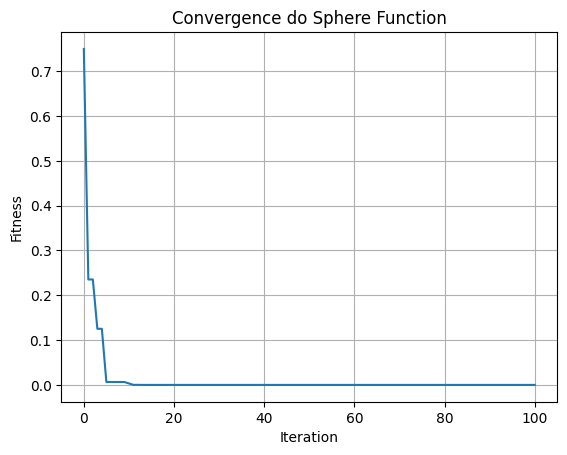

In [11]:
# Sphere Test
dim = 2
bounds = (-5.12, 5.12)
n_whales=30
max_iter=100
best_position, best_value, history = WOA(sphere, dim, bounds, n_whales, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do Sphere Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()



Iteration 1: New solution accepted [-4.28349385  2.49090603], fobj: 12.247257613823194
Iteration 2: New solution accepted [3.88862967 2.738633  ], fobj: 11.09643069123985
Iteration 3: New solution accepted [3.88862967 2.738633  ], fobj: 11.09643069123985
Iteration 4: New solution accepted [-1.3667608  0.7540203], fobj: 5.955393062207289
Iteration 5: New solution accepted [-1.3667608  0.7540203], fobj: 5.955393062207289
Iteration 6: New solution accepted [-1.01013934  2.11331373], fobj: 5.952896900587383
Iteration 7: New solution accepted [-0.52551165  0.08667612], fobj: 3.2331957116079804
Iteration 8: New solution accepted [-0.27116466  0.28339635], fobj: 2.954176021437704
Iteration 9: New solution accepted [-0.27116466  0.28339635], fobj: 2.954176021437704
Iteration 10: New solution accepted [-0.08212525 -0.26323294], fobj: 2.0012278635622924
Iteration 11: New solution accepted [-0.08212525 -0.26323294], fobj: 2.0012278635622924
Iteration 12: New solution accepted [-0.06982189 -0.2400

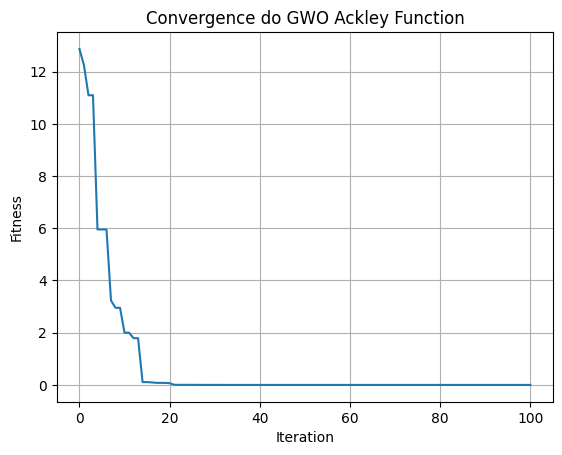

In [12]:
## Ackley test
dim = 2
bounds = (-32.768, 32.768)
n_whales=30
max_iter=100
best_position, best_value, history = WOA(ackley, dim, bounds, n_whales, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Ackley Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


Iteration 1: New solution accepted [3.12759432 9.58503454], fobj: 8.400142099624755
Iteration 2: New solution accepted [ 3.18142686 10.        ], fobj: 6.234285742424859
Iteration 3: New solution accepted [ 3.18142686 10.        ], fobj: 6.234285742424859
Iteration 4: New solution accepted [ 3.18142686 10.        ], fobj: 6.234285742424859
Iteration 5: New solution accepted [1.98713025 3.88265992], fobj: 1.4103787382476876
Iteration 6: New solution accepted [1.98713025 3.88265992], fobj: 1.4103787382476876
Iteration 7: New solution accepted [1.99607015 3.98621595], fobj: 0.9925243474622683
Iteration 8: New solution accepted [1.99607015 3.98621595], fobj: 0.9925243474622683
Iteration 9: New solution accepted [1.99529753 3.97726626], fobj: 0.9921742278613115
Iteration 10: New solution accepted [1.99529753 3.97726626], fobj: 0.9921742278613115
Iteration 11: New solution accepted [1.99529753 3.97726626], fobj: 0.9921742278613115
Iteration 12: New solution accepted [1.99529753 3.97726626], 

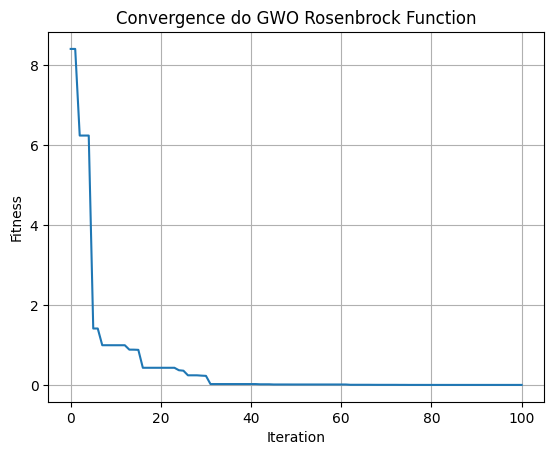

In [13]:
# rosen Test
dim = 2
bounds = (-5, 10)
n_whales=30
max_iter=100
best_position, best_value, history = WOA(rosen, dim, bounds, n_whales, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Rosenbrock Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


### Reference

Mirjalili, S., & Lewis, A. (2016). *The Whale Optimization Algorithm*. Advances in Engineering Software, 95, 51–67. https://doi.org/10.1016/j.advengsoft.2016.01.008
